# Studying Maximum Rainfall

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pprint import pprint

from ts.utility import Utility
from ts.experimental import GeneralizedExtremeValueDistribution, GevEstimate, Pso
from ts.decompose import StlDecompose

## Load Dataset

In [2]:
rainfall_df = pd.read_csv('../datasets/rainfall-data.csv')[['YEAR', 'MN', 'DT', '..R/F']]
rainfall_df

,YEAR,MN,DT,..R/F
0,1970,1,1,0.0
1,1970,1,2,3.2
2,1970,1,3,0.0
3,1970,1,4,0.0
4,1970,1,5,0.0
...,...,...,...,...
17647,2018,4,26,0.0
17648,2018,4,27,2.1
17649,2018,4,28,0.0
17650,2018,4,29,0.0


## Plot Entire Data

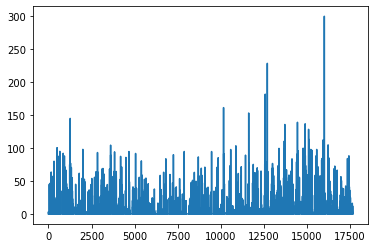

In [3]:
_ = plt.plot(rainfall_df['..R/F'].to_numpy())

## Helper Functions

In [4]:
def get_most_likely_point(shape, location, scale, low, high, num_particles, num_iter):
    
    def min_func(x):
        
        log_lkhd = GeneralizedExtremeValueDistribution\
            .logLikelihood(shape, location, scale, np.array([x]))
        
        return -log_lkhd if log_lkhd is not None else np.inf
    
    init_pos = Pso.computeInitialPos([(low, high)], num_particles)
    
    return Pso.pso(min_func, init_pos, numIterations=num_iter)

In [5]:
def get_return_level(shape, location, scale, prob):
    
    if shape == 0:
        return location - scale * np.log(-np.log(1 - prob))
        
    return location - (scale / shape) * (1 - ((-np.log(1 - prob)) ** (-shape)))

# Fitting GEV to Monthly Maximum

## Computing monthly maximum

Data Type: float64, Data Shape: (580,)

First 10 data points:
[3.2, 45.0, 0.0, 47.0, 25.2, 63.6, 39.0, 57.0, 27.0, 30.0]

Last 10 data points:
[58.0, 54.2, 88.2, 41.1, 15.2, 24.8, 0.0, 12.6, 14.8, 16.2]


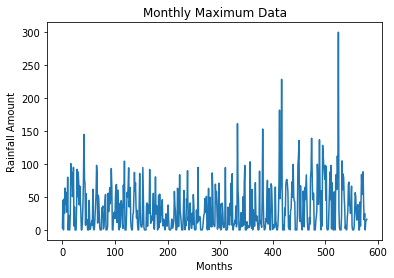

In [6]:
month_max_series = [rainfall_df.iloc[0]['..R/F']]
prev_month = rainfall_df.iloc[0]['MN']

for _, row in rainfall_df.iloc[1:].iterrows():
    
    if row['MN'] == prev_month:
        month_max_series[-1] = max(month_max_series[-1], row['..R/F'])
        
    else:
        month_max_series.append(row['..R/F'])
        
    prev_month = row['MN']
    
month_max_series = np.array(month_max_series)

print(f'Data Type: {month_max_series.dtype}, Data Shape: {month_max_series.shape}\n')
print('First 10 data points:')
pprint(list(month_max_series[:10]))
print('')

print('Last 10 data points:')
pprint(list(month_max_series[-10:]))

plt.plot(month_max_series)
plt.title('Monthly Maximum Data')
plt.xlabel('Months')
plt.ylabel('Rainfall Amount')
plt.show()

## 1) Fitting GEV to monthly data using ML estimation (PSO)

### Fit GEV params using PSO on data

Shape Parameter: 1.1356359402699887 
Location Parameter: 7.486399747410801 
Scale Parameter: 12.032791511993521 
Log Likelihood: -2689.128555090656


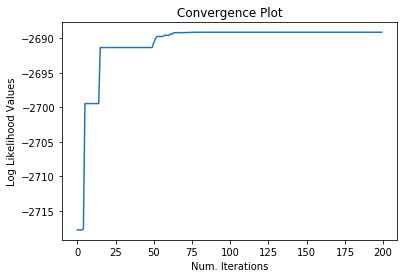

In [7]:
params, max_log_likelihood, max_log_likelihood_vals = GevEstimate.psoMethod(
    month_max_series,
    Pso.computeInitialPos([(-10, 10), (0, 100), (1, 10)], 200),
    numIterations=200
)

shape, location, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Location Parameter: {location} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

### Plot PDF and CDF

/Users/ahmed/Programming/Project/Forecast/ts/experimental/genextreme.py:79: RuntimeWarning: invalid value encountered in power
  / self.scaleParam


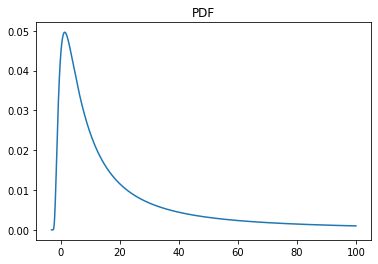

/Users/ahmed/Programming/Project/Forecast/ts/experimental/genextreme.py:95: RuntimeWarning: invalid value encountered in power
  return np.exp(- ((1 + self.shapeParam * transformData) ** (-1. / self.shapeParam)))


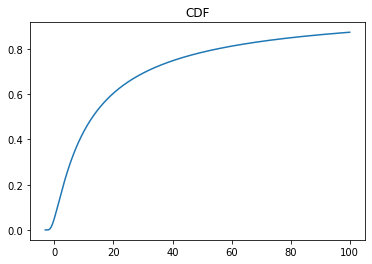

In [8]:
x = np.linspace(-5, 100, 10000)

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).pdf(x)
)
plt.title('PDF')
plt.show()

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).cdf(x)
)
plt.title('CDF')
plt.show()

### Compute Return Levels for Input Probabilities

Given p, compute the value z such that probability for exceeding
z in the next month is p. z is called the p - return level for a
particular p.

In [9]:
prob = float(input('Enter Probability p: '))
print('Return Level for p = %0.3f is %0.3f'
      %(prob, get_return_level(shape, location, scale, prob)))

Enter Probability p: 0
Return Level for p = 0.000 is inf


/Users/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


### Get the point with the highest probability density

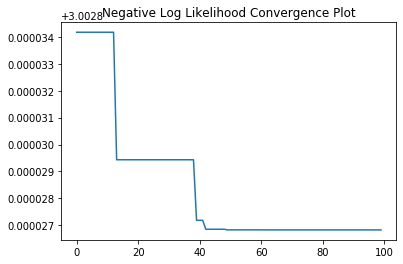

Point with the highest density: 1.3669047098435334
Negative Log Likelihood of this point: 3.002826824103183


In [10]:
most_likely_point, min_neg_log_lkhd, lkhd_vals \
    = get_most_likely_point(shape, location, scale, 20, 300, 200, 100)

plt.plot(lkhd_vals)
plt.title('Negative Log Likelihood Convergence Plot')
plt.show()

print(f'Point with the highest density: {most_likely_point[0]}\n'
    + f'Negative Log Likelihood of this point: {min_neg_log_lkhd}')

## 2) Fitting GEV to trend and seasonality removed data

### Decompose the time series into trend, seasonality and remainder components

In [7]:
trend_series, seasonality_series, remainder_series = StlDecompose\
    .decompose(np.expand_dims(month_max_series, axis=1), 
        period=12, seasonal=101, robust=True)

### Plot trend, seasonality and remainder components

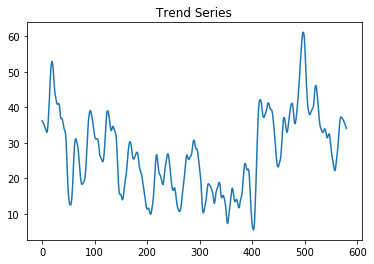

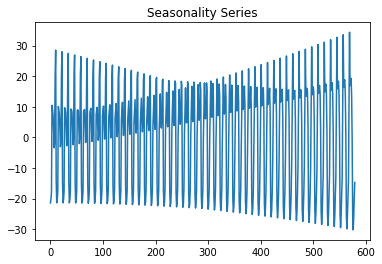

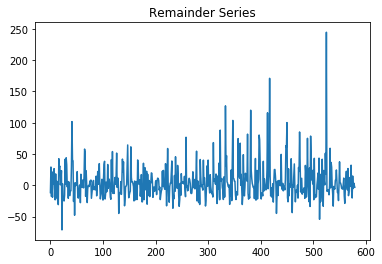

In [8]:
plt.plot(trend_series)
plt.title('Trend Series')
plt.show()

plt.plot(seasonality_series)
plt.title('Seasonality Series')
plt.show()

plt.plot(remainder_series)
plt.title('Remainder Series')
plt.show()

### Compare the inferred seasonality with actual data

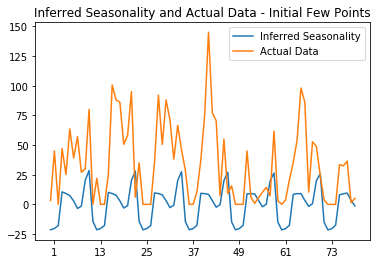

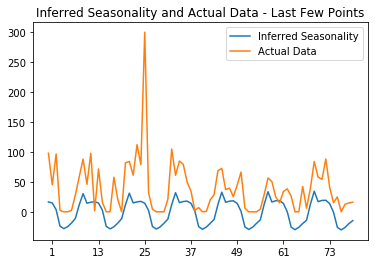

In [9]:
# Front Few Points
num_initial_points = 80

plt.plot(seasonality_series[:num_initial_points], label='Inferred Seasonality')
plt.plot(month_max_series[:num_initial_points], label='Actual Data')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Initial Few Points')
plt.xticks(np.arange(1, num_initial_points, 12))
plt.show()

# Last Few Points
num_last_points = 80

plt.plot(seasonality_series[-num_last_points:], label='Inferred Seasonality')
plt.plot(month_max_series[-num_last_points:], label='Actual Data')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Last Few Points')
plt.xticks(np.arange(1, num_last_points, 12))
plt.show()

### Fitting GEV parameters using PSO to remainder series

Shape Parameter: -0.009297859916586793 
Location Parameter: -6.466789997619216 
Scale Parameter: 20.806597388182215 
Log Likelihood: -2660.618085806681


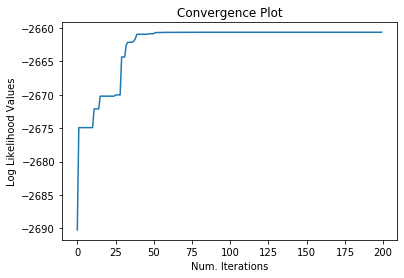

In [10]:
params, max_log_likelihood, max_log_likelihood_vals = GevEstimate.psoMethod(
    remainder_series,
    Pso.computeInitialPos([(-10, 10), (-10, 10), (5, 30)], 200),
    numIterations=200
)

shape, location, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Location Parameter: {location} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

### Plot PDF and CDF

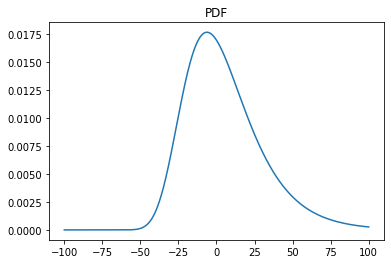

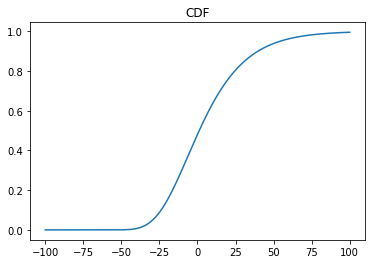

In [11]:
x = np.linspace(-100, 100, 10000)

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).pdf(x)
)
plt.title('PDF')
plt.show()

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).cdf(x)
)
plt.title('CDF')
plt.show()

### Compute Return Levels for Input Probabilities

Given p, compute the value z such that probability for exceeding z in the next month is p. z is called the p - return level for a particular p

In [12]:
prob = float(input('Enter Probability p: '))
print('Return Level for p = %0.3f is %0.3f'
      %(prob, get_return_level(shape, location, scale, prob)))

Enter Probability p: 1
Return Level for p = 1.000 is -inf


/Users/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


### Get the point with the highest probability density

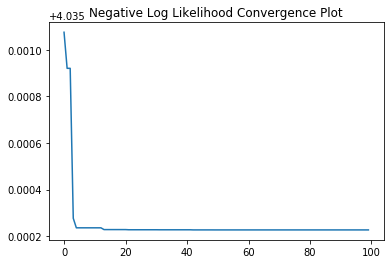

Point with the highest density: -6.272436492116874
Negative Log Likelihood of this point: 4.035226758847014


In [13]:
most_likely_point, min_neg_log_lkhd, lkhd_vals \
    = get_most_likely_point(shape, location, scale, 20, 300, 200, 100)

plt.plot(lkhd_vals)
plt.title('Negative Log Likelihood Convergence Plot')
plt.show()

print(f'Point with the highest density: {most_likely_point[0]}\n'
    + f'Negative Log Likelihood of this point: {min_neg_log_lkhd}')

### Compute CDF of each data point in remainder series

Data Type: float64, Data Shape: (580, 1)

First 5 data points:
array([[0.2785786 ],
       [0.83782778],
       [0.17888047],
       [0.49895115],
       [0.1612995 ]])

Last 5 data points:
array([[0.70057799],
       [0.39164452],
       [0.54158102],
       [0.48044212],
       [0.42682192]])


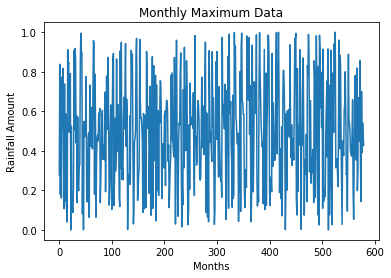

In [14]:
remainder_series_cdf = GeneralizedExtremeValueDistribution(*tuple(params))\
    .cdf(remainder_series)

print(f'Data Type: {remainder_series_cdf.dtype}, Data Shape: {remainder_series_cdf.shape}\n')
print('First 5 data points:')
pprint(remainder_series_cdf[:5])
print('')

print('Last 5 data points:')
pprint(remainder_series_cdf[-5:])

plt.plot(remainder_series_cdf)
plt.title('Monthly Maximum Data')
plt.xlabel('Months')
plt.ylabel('Rainfall Amount')
plt.show()

## Build Model for Forecasting next day CDF

### LSTM

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

model = Sequential([
    LSTM(units=16, return_sequences=True, activation='relu'),
    LSTM(units=32, return_sequences=True, activation='relu'),
    LSTM(units=64, return_sequences=True, activation='relu'),
    LSTM(units=32, return_sequences=True, activation='relu'),
    LSTM(units=16, return_sequences=True, activation='relu'),
    TimeDistributed(Dense(units=1, activation=None))
])

model.build(input_shape=(None, None, 1))
model.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss=tf.losses.MeanSquaredError()
)

In [20]:
input_data = np.expand_dims(remainder_series[:-1], axis=0)
output_data = np.expand_dims(remainder_series_cdf[1:], axis=0)

print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (1, 579, 1)
Output Data Shape: (1, 579, 1)


In [21]:
model.fit(input_data, output_data, epochs=10)

Epoch 1/10
1/1 [==============================] - 0s 815us/step - loss: 0.1603
Epoch 2/10
1/1 [==============================] - 0s 999us/step - loss: 0.1090
Epoch 3/10
1/1 [==============================] - 0s 990us/step - loss: 0.1315
Epoch 4/10
1/1 [==============================] - 0s 1ms/step - loss: 0.1077
Epoch 5/10
1/1 [==============================] - 0s 778us/step - loss: 0.0945
Epoch 6/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0931
Epoch 7/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0932
Epoch 8/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0909
Epoch 9/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0865
Epoch 10/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0816


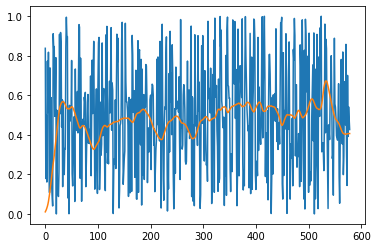

In [22]:
plt.plot(np.squeeze(output_data))
plt.plot(np.squeeze(model.predict(input_data)))

### DNN

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

lag = 50

model = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, lag))
model.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

In [17]:
input_data = []
output_data = []

for i in range(lag + 1, remainder_series.shape[0]):
    input_data.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    output_data.append(remainder_series_cdf[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (529, 50)
Output Data Shape: (529, 1)


Epoch 1/100
17/17 [==============================] - 0s 780us/step - loss: 0.0264
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0264
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 11/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0264
Epoch 12/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 13/100
17/17 [===============

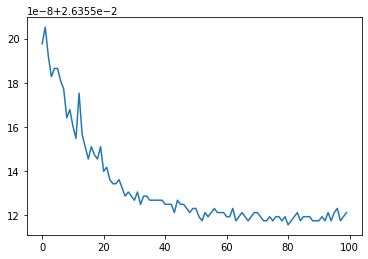

In [27]:
history = model.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

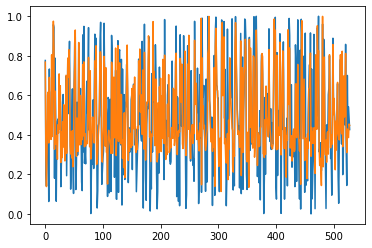

In [28]:
plt.plot(np.squeeze(output_data))
plt.plot(np.squeeze(model.predict(input_data)))

## Time Pass !!!

In [29]:
pred = GeneralizedExtremeValueDistribution(*tuple(params)) \
    .computeQuantile(model.predict(input_data))

pred = np.maximum(pred + trend_series[lag + 1:] + seasonality_series[lag + 1:], 0)
true = month_max_series[lag + 1:]

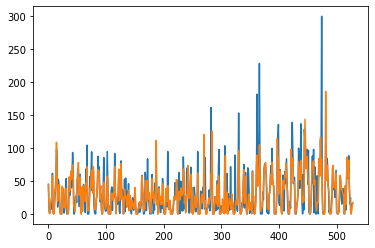

In [30]:
plt.plot(true, label='true')
plt.plot(pred, label='pred')
plt.show()

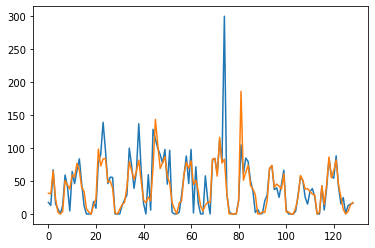

In [31]:
plt.plot(true[400:], label='true')
plt.plot(pred[400:], label='pred')
plt.show()

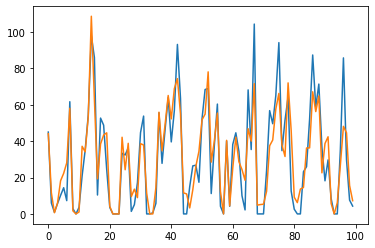

In [32]:
plt.plot(true[:100], label='true')
plt.plot(pred[:100], label='pred')
plt.show()